In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps


In [2]:
import os
import torch
import csv

from pathlib import Path
import io
import lmdb
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import (
    view_points,
    box_in_image,
    BoxVisibility,
    transform_matrix,
)
from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.utils.data_classes import LidarPointCloud

from src import utils

In [3]:
from collections import namedtuple

In [4]:
from src.data.dataloader import nuScenesMaps

In [5]:
def read_split(filename):
    """
    Read a list of NuScenes sample tokens
    """
    with open(filename, "r") as f:
        lines = f.read().split("\n")
        return [val for val in lines if val != ""]

In [6]:
Args = namedtuple('Args', ['root', 
                           'train_split', 
                           'grid_size', 
                           'grid_res', 
                           'load_classes_nusc', 
                           'data_size', 
                           'desired_image_size'])

In [57]:
len(load_classes_nusc), len()

16

In [7]:
z_range = [1.0, 9.0, 21.0, 39.0, 51.0]
grid_size = (z_range[-1] - z_range[0], z_range[-1] - z_range[0])

load_classes_nusc = [
    "drivable_area",
    "ped_crossing",
    "walkway",
    "carpark_area",
    "road_segment",
    "lane",
    "bus",
    "bicycle",
    "car",
    "construction_vehicle",
    "motorcycle",
    "trailer",
    "truck",
    "pedestrian",
    "trafficcone",
    "barrier",
]


args = Args(root= os.path.join(os.getcwd(), 'nuscenes_data'), # translating-images-into-maps/nuscenes_data
            train_split='train_mini',            # ground truth name
            grid_size=grid_size,                 # width and depth of validation grid, in meters
            grid_res=0.5,                        # size of grid cells, in meters
            load_classes_nusc=load_classes_nusc, # Classes to load for NuScenes
            data_size=0.2,                       # percentage of dataset to train on
            desired_image_size=[1600, 900]       #size images are padded to before passing to network
           )
args

Args(root='/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps/nuscenes_data', train_split='train_mini', grid_size=(50.0, 50.0), grid_res=0.5, load_classes_nusc=['drivable_area', 'ped_crossing', 'walkway', 'carpark_area', 'road_segment', 'lane', 'bus', 'bicycle', 'car', 'construction_vehicle', 'motorcycle', 'trailer', 'truck', 'pedestrian', 'trafficcone', 'barrier'], data_size=0.2, desired_image_size=[1600, 900])

In [ ]:
# train_data = nuScenesMaps(
#         root=args.root,
#         split=args.train_split,
#         grid_size=args.grid_size,
#         grid_res=args.grid_res,
#         classes=args.load_classes_nusc,
#         dataset_size=args.data_size,
#         desired_image_size=args.desired_image_size,
#         mini=True,
#         gt_out_size=(100, 100),
#     )

In [8]:
grid_size=args.grid_size
grid_res=args.grid_res
split="train_mini"
dataset_size = args.data_size
desired_image_size = args.desired_image_size
gt_out_size = (100, 100)
root = os.path.join(args.root)
gtmaps_db_path = os.path.join(
            root, "lmdb",
            "semantic_maps_new_200x200"
        )
images_db_path = os.path.join(
            root, "lmdb",
            "samples", "CAM_FRONT"
        )
nusc = NuScenes(version="v1.0-mini",
                                 dataroot=root,
                                 verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.304 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [27]:
fname = os.path.join(root, "splits", "{}.txt".format(split))
tokens = read_split(
            os.path.join(root, "splits", "{}.txt".format(split))
        )
fname, len(tokens)

('/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps/nuscenes_data/splits/train_mini.txt',
 323)

In [28]:
gtmaps_db = lmdb.open(
            path=gtmaps_db_path,
            readonly=True,
            readahead=False,
            max_spare_txns=128,
            lock=False,
        )

In [35]:
classes = list(args.load_classes_nusc)
classes.append("lidar_ray_mask_dense")
class2idx = {
            name: idx for idx, name in enumerate(classes)
        }
class2idx

{'drivable_area': 0,
 'ped_crossing': 1,
 'walkway': 2,
 'carpark_area': 3,
 'road_segment': 4,
 'lane': 5,
 'bus': 6,
 'bicycle': 7,
 'car': 8,
 'construction_vehicle': 9,
 'motorcycle': 10,
 'trailer': 11,
 'truck': 12,
 'pedestrian': 13,
 'trafficcone': 14,
 'barrier': 15,
 'lidar_ray_mask_dense': 16}

In [37]:
nusc_classes = [
            "vehicle.bus",
            "vehicle.bicycle",
            "vehicle.car",
            "vehicle.construction",
            "vehicle.motorcycle",
            "vehicle.trailer",
            "vehicle.truck",
            "human.pedestrian",
        ]
nuscclass2idx = {
            name: idx for idx, name in enumerate(nusc_classes)
        }
nuscclass2idx

{'vehicle.bus': 0,
 'vehicle.bicycle': 1,
 'vehicle.car': 2,
 'vehicle.construction': 3,
 'vehicle.motorcycle': 4,
 'vehicle.trailer': 5,
 'vehicle.truck': 6,
 'human.pedestrian': 7}

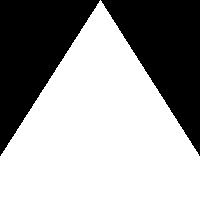

In [38]:
fov_mask = Image.open(
            os.path.join(root, "lmdb", "semantic_maps_new_200x200", "fov_mask.png")
        )
fov_mask

In [44]:
grid_offset = (-grid_size[0] / 2.0, 0.0)
grid_size, grid_offset, grid_res

((50.0, 50.0), (-25.0, 0.0), 0.5)

In [46]:
grid2d = utils.make_grid2d(grid_size, (-grid_size[0] / 2.0, 0.0), grid_res)
grid2d.shape

torch.Size([100, 100, 2])

In [50]:
fname = os.path.join(root, "splits", "{}.txt".format('val_mini'))
val_tokens = read_split(
            fname
        )
fname, len(val_tokens)

('/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps/nuscenes_data/splits/val_mini.txt',
 81)

In [51]:
tokens[0], val_tokens[0]

('ca9a282c9e77460f8360f564131a8af5', '3e8750f331d7499e9b5123e9eb70f2e2')

In [53]:
index = 0
sample_token = tokens[index]
sample_record = nusc.get("sample", sample_token)
sample_record

{'token': 'ca9a282c9e77460f8360f564131a8af5',
 'timestamp': 1532402927647951,
 'prev': '',
 'next': '39586f9d59004284a7114a68825e8eec',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
  'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
  'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
  'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
  'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
  'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
  'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
  'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
  'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
  'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
  'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
  'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'},
 'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319

In [54]:
cam_token = sample_record["data"]["CAM_FRONT"]
cam_token

'e3d495d4ac534d54b321f50006683844'

In [56]:
cam_record = nusc.get("sample_data", cam_token)
cam_record

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [57]:
cam_path = nusc.get_sample_data_path(cam_token)
cam_path

'/Users/deepakduggirala/Documents/autonomous-robotics/translating-images-into-maps/nuscenes_data/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg'

In [58]:
id = Path(cam_path).stem
id

'n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460'

In [60]:
len(tokens) + len(val_tokens)

404

In [76]:
original_nusenes_dir = Path.resolve(Path('../v1.0-mini/samples/CAM_FRONT'))

In [77]:
new_cam_path = original_nusenes_dir / Path(cam_path).name
new_cam_path

PosixPath('/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg')

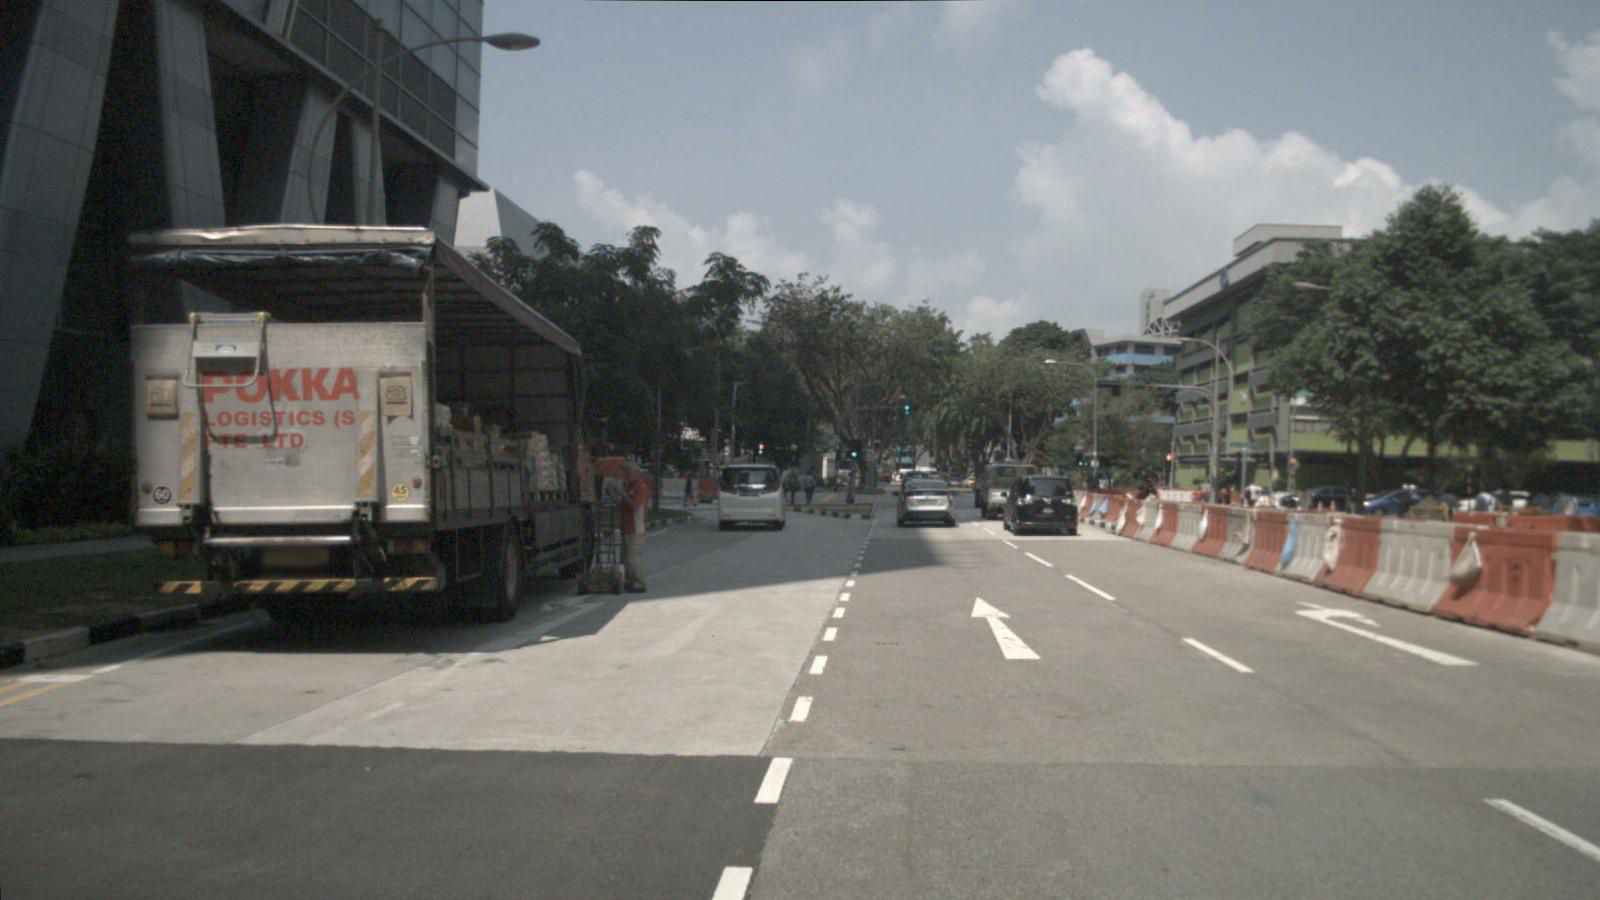

In [78]:
Image.open(new_cam_path).convert(mode='RGB')

In [79]:
id

'n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460'

In [179]:
classes

['drivable_area',
 'ped_crossing',
 'walkway',
 'carpark_area',
 'road_segment',
 'lane',
 'bus',
 'bicycle',
 'car',
 'construction_vehicle',
 'motorcycle',
 'trailer',
 'truck',
 'pedestrian',
 'trafficcone',
 'barrier',
 'lidar_ray_mask_dense']

In [180]:
classes.index('truck')

12

In [153]:
gtmaps_key = [pickle.dumps("{}___{}".format(id, cls), 3) for cls in classes]
gtmaps_key[0] 

b'\x80\x03XJ\x00\x00\x00n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460___drivable_areaq\x00.'

In [156]:
with gtmaps_db.begin() as txn:
    value = [txn.get(key=key) for key in gtmaps_key]
    gtmaps = [Image.open(io.BytesIO(im)) for im in value]

In [183]:
type(gtmaps[12])

PIL.PngImagePlugin.PngImageFile

In [88]:
with gtmaps_db.begin() as txn:
    keys = list(txn.cursor().iternext(values=False))

In [131]:
len(keys), keys[3], pickle.loads(keys[3])

(1009102,
 b'\x80\x03X@\x00\x00\x00n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915243012465___carq\x00.',
 'n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915243012465___car')

In [118]:
split_keys = [pickle.loads(key).split('___') for key in keys]

In [123]:
from collections import defaultdict
d = defaultdict(list)
for xs in split_keys:
    if len(xs) == 2:
        d[xs[0]].append(xs[1])

In [124]:
len(d.keys())

34149

In [136]:
id in d, 'car' in d[id]

(True, True)

In [149]:
test_key = pickle.dumps("{}___{}".format(id, 'car'), 3)
test_key in keys

True

In [138]:
matched_keys = [key for key in keys if pickle.loads(key).split('___')==[id, 'car']]

In [150]:
test_key, matched_keys[0], test_key == matched_keys[0]

(b'\x80\x03X@\x00\x00\x00n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460___carq\x00.',
 b'\x80\x03X@\x00\x00\x00n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460___carq\x00.',
 True)

In [151]:
pickle.loads(test_key) == pickle.loads(matched_keys[0])

True

In [166]:
len(tokens), len(val_tokens)

(323, 81)

In [18]:
import torch
from collections import OrderedDict

In [ ]:
# train --pretrained-bem --pretrained-model --load-ckpt

# otherwise can resume training if the model dir has checkpoints in it *.pth.gz

# expects pretrained models to be in experiments/pretrained_models

savedir = os.path.join(os.getcwd(), 'experiments')
pretrained_model_dir = '/Users/deepakduggirala/Documents/autonomous-robotics/autonomous-robotics-project/pretrained_models'
load_ckpt = 'checkpoint-0008.pth.gz'
pretrained_pth = os.path.join(pretrained_model_dir, load_ckpt)
pretrained_dict = torch.load(pretrained_pth, map_location=torch.device('cpu'))["model"]
pretrained_dict


In [19]:
ignore = ["nothing"]
mod_dict = OrderedDict()

for k, v in pretrained_dict.items():
    if any(module in k for module in ignore):
        continue
    else:
        name = k[7:]
        mod_dict[name] = v


In [24]:
list(pretrained_dict.keys())[:5]

['module.mean', 'module.std', 'module.z_idx', 'module.h_start', 'module.h_end']

In [23]:
list(mod_dict.keys())[:5]

['mean', 'std', 'z_idx', 'h_start', 'h_end']

In [27]:
name = 'tiim_220613'
model_dir = os.path.join(savedir, name)
checkpt_fn = sorted(
        [
            f
            for f in os.listdir(model_dir)
            if os.path.isfile(os.path.join(model_dir, f)) and ".pth.gz" in f
        ]
    )
checkpt_fn

[]

In [29]:
from collections import defaultdict

In [30]:
class MetricDict(defaultdict):
    def __init__(self):
        super().__init__(float)
        self.count = defaultdict(int)

    def __add__(self, other):
        for key, value in other.items():
            self[key] += value
            self.count[key] += 1
        return self

    @property
    def mean(self):
        return {key: self[key] / self.count[key] for key in self.keys()}

In [51]:
m = MetricDict()
m=m + {'a':1}

In [53]:

m, m.count, m.mean

(MetricDict(float, {'a': 1.0}), defaultdict(int, {'a': 1}), {'a': 1.0})

In [45]:
class Parrot:
    def __init__(self):
        self._voltage = 100000

    @property
    def voltage(self):
        """Get the current voltage."""
        return self._voltage

In [49]:
p = Parrot()
p.voltage

100000